- 2121221009 Nurgül ŞAHİN
- 2221221024 Öykü Azra YILMAZ
- 2221221046 İrem AYVAZ

**Problem definition :** TSP (Traveling Salesman Problem)
- Amaç: Tüm şehirleri bir kez ziyaret edip başlangıç noktasına dönecek en kısa rotayı bulmak
- Girdi: Şehirler arası mesafe matrisi
- Çıktı: Optimal/optimal-yakın rota ve toplam mesafe

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path
import time
import traceback
import random
from sklearn.model_selection import ParameterGrid

random.seed(42)
np.random.seed(42)

### Gerekli Sınıflar

- **CITY :**  Şehri temsil eder.

In [6]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return f"City({self.x:.1f},{self.y:.1f})"

    def __str__(self):
        return f"({self.x:.1f}, {self.y:.1f})"
    
    def print_info(self):
        print(f"City Coordinates: {self.x}, {self.y}")

- **INDIVIDUAL :** Bir çözümü(rotayı) temsil eder.

In [8]:
class Individual:
    def __init__(self, tour_order=None):
        self.tour_order = tour_order if tour_order else [] # şehir listesinin bir permütasyonu
        self.fitness = None # az tur uzunluğu, iyi fitness
        self.distance_value = None # toplam mesafe
    
    def calculate_distance(self, c1, c2): # şehirler arası uzaklık
        return math.hypot(c1.x - c2.x, c1.y - c2.y)
    
    def calculate_fitness(self, distance_matrix=None): # toplam rota mesafesi (toplam alınan yol)
        if self.fitness is not None: # fitness'ı zaten hesaplanmış
            return self.fitness

        if not self.tour_order or len(self.tour_order) == 0: # boş tour kontrolü
            self.fitness = 0
            self.distance_value = float('inf')
            return self.fitness
            
        if distance_matrix is None:  
            raise ValueError("Distance matrix gerekli! GA doğru initialize edilmedi.")
            
        total_distance = 0
        num_cities = len(self.tour_order)

        for i in range(num_cities):
            from_city = self.tour_order[i] # Başlangıçtan son şehre
            to_city = self.tour_order[(i + 1) % num_cities]  # Son şehirden başlangıca
            total_distance += distance_matrix[from_city][to_city]

        
        self.distance_value = total_distance
        self.fitness = 1 / (total_distance + 1e-10)  # Küçük mesafe = yüksek fitness
        return self.fitness

    def get_total_distance(self): # Toplam mesafeyi döndür
        return self.distance_value if self.distance_value is not None else float('inf')

    def reset_fitness(self): # Fitness değerlerini sıfırla (mutation/crossover sonrası)
        self.fitness = None
        self.distance_value = None

- **GENETIC ALGORITHM**

In [10]:
class GA:
    def __init__(self, cities, pop_size=100, termination=1000, 
                 crossover_rate=0.8, mutation_rate=0.02, elitism_rate=0.1, tournament_size=5):
        self.cities = cities # şehir listesi
        self.pop_size = pop_size # population size
        self.population = []
        self.termination = termination # Kaç nesil çalışacak?
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism_count = int(pop_size * elitism_rate)
        self.num_cities = len(cities)
        self.tournament_size = tournament_size
        
        # Distance matrix oluştur
        self.distance_matrix = DistanceMatrixCache.get_matrix(cities, self.num_cities)
        
        # GA state
        self.population = []
        self.generation = 0
        self.best_distances = []
        self.avg_distances = []

    def initialize_population(self): # POP_SIZE KADAR RASTGELE ROTA OLUŞTURUR
        for _ in range(self.pop_size):
            tour = list(range(self.num_cities))  
            random.shuffle(tour)   
            
            individual = Individual(tour)        
            individual.calculate_fitness(self.distance_matrix) # HER ROTANIN FITNESS'I HESAPLANIR
            self.population.append(individual)

        self.population.sort(key=lambda x: x.get_total_distance()) # EN İYİ ROTADAN EN KÖTÜYE SIRALANIR
        
        best_distance = self.population[0].get_total_distance()
        worst_distance = self.population[-1].get_total_distance()
        avg_distance = sum(ind.get_total_distance() for ind in self.population) / len(self.population)
        
        print(f"✅ İlk populasyon hazır:")
        print(f"   En iyi: {best_distance:.2f}")
        print(f"   En kötü: {worst_distance:.2f}")
        print(f"   Ortalama: {avg_distance:.2f}")
        
        return best_distance

    def tournament_selection(self): # TOURNAMENT_SIZE KADAR RASTGELE BİREY ARASINDAN EN İYİYİ SEÇER
        tournament_size = min(self.tournament_size, len(self.population))
        tournament = random.sample(self.population, tournament_size)
        return min(tournament, key=lambda x: x.get_total_distance())
    
    def crossover(self, parent1, parent2): # İKİ EBEVEYNDEN BİR ÇOCUK
        size = len(parent1.tour_order)
        
        # rastgele 2 nokta seçilir
        start, end = sorted(random.sample(range(size), 2)) 
        child_tour = [-1] * size # bu satır ne yapıyor?
        child_tour[start:end] = parent1.tour_order[start:end]
        
        pointer = end
        for city in parent2.tour_order[end:] + parent2.tour_order[:end]:
            if city not in child_tour: # AVOID DUPLICATION
                child_tour[pointer % size] = city
                pointer += 1

        child = Individual(child_tour)
        child.calculate_fitness(self.distance_matrix)
        
        return child
    
    def mutate(self, individual): # İKİ RASTGELE ŞEHRİN YERİ DEĞİŞİR
        tour = individual.tour_order.copy()
        
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
        
        mutated = Individual(tour)
        mutated.calculate_fitness(self.distance_matrix)
        return mutated
        
    def evolve_generation(self):
        new_population = []
        mutation_count = 0

        new_population.extend(self.population[:self.elitism_count]) # en iyiler doğru bir şekilde aktarılıyor mu?

        while len(new_population) < self.pop_size:
             parent1 = self.tournament_selection()
             parent2 = self.tournament_selection()
    
             if random.random() < self.crossover_rate:
                 child = self.crossover(parent1, parent2)
             else:
                 # Crossover yapılmazsa parent1'i kopyala - MATRIX'İ BAĞLA!
                child = Individual(parent1.tour_order.copy())
                child.calculate_fitness(self.distance_matrix)
             
             if random.random() < self.mutation_rate:
                child = self.mutate(child)
                mutation_count += 1  # Mutation sayacı
            
             new_population.append(child)
        
        # Mutation istatistiği (debug için)
        if self.generation % 100 == 0:
            print(f"   Nesil {self.generation}: {mutation_count} mutasyon yapıldı")
        
        # Yeni populasyonu ata ve sırala
        self.population = new_population
        self.population.sort(key=lambda x: x.get_total_distance())
        
        # İstatistikleri güncelle
        distances = [ind.get_total_distance() for ind in self.population]
        self.best_distances.append(min(distances))
        self.avg_distances.append(sum(distances) / len(distances))
        
        self.generation += 1
        
    def run(self):
        print(f"🧬 GA başlıyor ({self.termination} nesil)...")
        
        t0 = time.perf_counter()
        initial = self.initialize_population()
        
        for gen in range(self.termination):
            self.evolve_generation()
            
            if gen % 100 == 0:
                current_best = self.population[0].get_total_distance()
                print(f"   Nesil {gen}: En iyi = {current_best:.2f}")
                
        t1 = time.perf_counter()
        
        # Final results
        best_solution = self.population[0]
        final_distance = best_solution.get_total_distance()
        improvement = ((initial - final_distance) / initial) * 100
        runtime = t1 - t0
        
        print(f"\n SONUÇLAR:")
        print(f"   İlk en iyi : {initial:.2f}")
        print(f"   Final en iyi : {final_distance:.2f}")
        print(f"   İyileştirme : {improvement:.1f}%")
        print(f"   En iyi rota : {best_solution.tour_order}")
        print(f"   Runtime : {runtime:.4f} s")
        
        return best_solution, runtime

    def plot_convergence(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_distances, label='En İyi', color='red', linewidth=2)
        plt.plot(self.avg_distances, label='Ortalama', color='blue', alpha=0.7)
        plt.xlabel('Nesil')
        plt.ylabel('Mesafe')
        plt.title(f'{self.num_cities} Şehir - GA Convergence')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_tour(self, individual=None):
        if individual is None:
            individual = self.population[0]
        
        plt.figure(figsize=(10, 8))
        
        # Cities
        x_coords = [city.x for city in self.cities]
        y_coords = [city.y for city in self.cities]
        plt.scatter(x_coords, y_coords, c='red', s=100, zorder=5)
        
        # City numbers
        for i, city in enumerate(self.cities):
            plt.annotate(str(i), (city.x, city.y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=12)
        
        # Route
        route_x = [self.cities[city_idx].x for city_idx in individual.tour_order]
        route_y = [self.cities[city_idx].y for city_idx in individual.tour_order]
        route_x.append(route_x[0])  # Return to start
        route_y.append(route_y[0])
        
        plt.plot(route_x, route_y, 'b-', alpha=0.7, linewidth=2)
        plt.title(f'{self.num_cities} Şehir - En İyi Rota (Mesafe: {individual.get_total_distance():.2f})')
        plt.xlabel('X Koordinatı')
        plt.ylabel('Y Koordinatı')
        plt.grid(True, alpha=0.3)
        plt.show()

- **MATRIX CACHE :** 2 şehir arası uzaklığı her seferinde hesaplamak yerine rotadaki tüm ikili eşleşmeler tek seferde hesaplanıp matriste tutulur.

In [12]:
class DistanceMatrixCache:
    _cache = {}  # Class-level cache
                 # Not be needed to create an object (instance)
    
    @classmethod
    def get_matrix(cls, cities, num): # matris varsa onu alır yoksa oluşturur
        if num in cls._cache: # cache'te var
            return cls._cache[num]
        
        matrix = cls.create_distance_matrix(cities) # cache'te yok oluştur
        cls._cache[num] = matrix
        return matrix
    
    @classmethod
    def create_distance_matrix(cls, cities):
        temp_individual = Individual()
        num_cities = len(cities)
        
        matrix = [[temp_individual.calculate_distance(cities[i], cities[j]) 
                  for j in range(num_cities)] 
                  for i in range(num_cities)]
        
        return matrix
    
    @classmethod
    def clear_cache(cls):
        cls._cache.clear()
    
    @classmethod
    def cache_info(cls):
        for i, num_cities in enumerate(cls._cache.keys()):
            print(f"   {i+1}. {num_cities} şehirli matrix")

### Veri okuma

In [14]:
def read_files():
    cities_dict = {}
    data_path = Path("Data")

    if not data_path.exists():
        print("Data klasörü bulunamadı!")
        return cities_dict
    
    for path in data_path.iterdir():
        if path.is_file() and path.name.startswith("tsp_"):
            print(path.name)
            try:
                with open(path, 'r') as file: # otomatik file.close() yapar

                    cities = []
                
                    try:
                        for line in file.readlines()[1:]: #2. satırdan itibaren okumaya başla
                            city_info = line.split()
                            city = City(float(city_info[0]), float(city_info[1]))
                            cities.append(city)
                    except ValueError as e:
                        print("Satır okunamadı.")
                    
                    cities_dict[len(cities)] = cities
                

            except Exception as e:
                print(f"{path.name} okunamadı")
    return cities_dict

In [15]:
cities = read_files()
print(cities)

tsp_70_1.txt
tsp_5_1.txt
tsp_100_1.txt
{70: [City(67.0,99.0), City(48.0,83.0), City(75.0,81.0), City(8.0,19.0), City(20.0,18.0), City(54.0,38.0), City(63.0,36.0), City(44.0,33.0), City(52.0,18.0), City(12.0,13.0), City(25.0,5.0), City(58.0,85.0), City(5.0,67.0), City(90.0,9.0), City(41.0,76.0), City(25.0,76.0), City(37.0,64.0), City(56.0,63.0), City(10.0,55.0), City(98.0,7.0), City(16.0,74.0), City(89.0,60.0), City(48.0,82.0), City(81.0,76.0), City(29.0,60.0), City(17.0,22.0), City(5.0,45.0), City(79.0,70.0), City(9.0,100.0), City(17.0,82.0), City(74.0,67.0), City(10.0,68.0), City(48.0,19.0), City(83.0,86.0), City(84.0,94.0), City(64.0,96.0), City(80.0,39.0), City(69.0,23.0), City(72.0,42.0), City(48.0,67.0), City(58.0,43.0), City(81.0,34.0), City(79.0,17.0), City(30.0,23.0), City(42.0,67.0), City(7.0,76.0), City(29.0,51.0), City(78.0,92.0), City(64.0,8.0), City(95.0,57.0), City(57.0,91.0), City(40.0,35.0), City(68.0,40.0), City(92.0,34.0), City(62.0,1.0), City(28.0,43.0), City(76.0,73

### ARRANGE THE CITY LIST SIZES FOR TSP

In [17]:
min_size = 0
avg_size = 0
max_size = 0

if 'cities' in globals() and cities:
    available_sizes = sorted(cities.keys())
    print(f"Available city list sizes: {available_sizes}")

    min_size = min(available_sizes) #   5 şehirli liste
    avg_size = available_sizes[1]   #  70 şehirli liste
    max_size = max(available_sizes) # 100 şehirli liste
    
    print(f"There are {min_size}, {avg_size}, {max_size} cities problems")

else:
    print("cities dict bulunamadı!")
    print("Önce şunu çalıştır: cities = read_files()")

Available city list sizes: [5, 70, 100]
There are 5, 70, 100 cities problems


### 5-Cities TSP

🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 4.00
   En kötü: 6.06
   Ortalama: 4.92
   Nesil 0: 0 mutasyon yapıldı
   Nesil 0: En iyi = 4.00
   Nesil 100: 1 mutasyon yapıldı
   Nesil 100: En iyi = 4.00

 SONUÇLAR:
   İlk en iyi : 4.00
   Final en iyi : 4.00
   İyileştirme : 0.0%
   En iyi rota : [1, 2, 3, 4, 0]
   Runtime : 0.0413 s
En iyi mesafe: 4.00


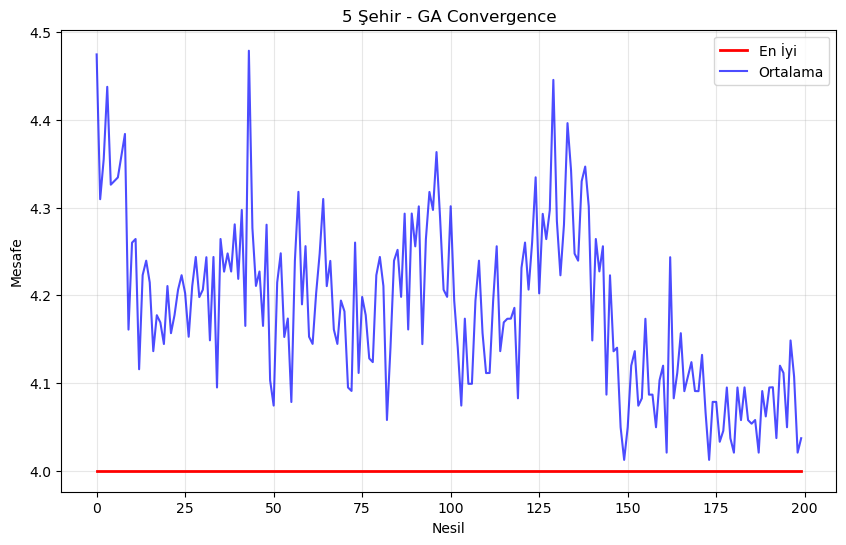

🗺️ Route grafiği çiziliyor...


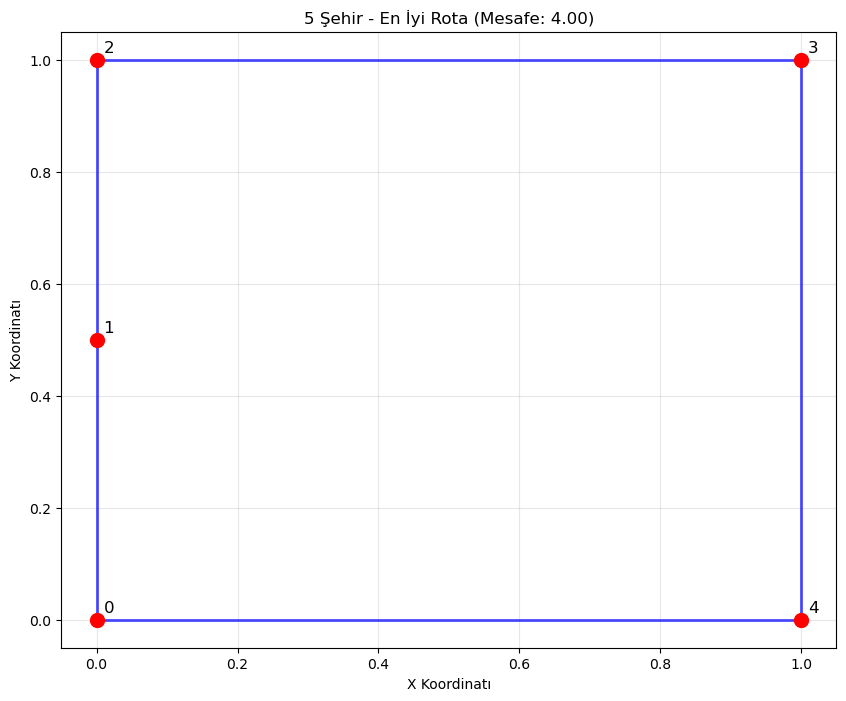

In [19]:
try:
    ga_real = GA(cities[min_size], 
                     pop_size=50, 
                     termination=200,
                     crossover_rate=0.8,
                     mutation_rate=0.02)
        
    best_solution, best_runtime = ga_real.run()
        
    print(f"En iyi mesafe: {best_solution.get_total_distance():.2f}")
        
    ga_real.plot_convergence()
        
    if min_size <= 100:
        print("🗺️ Route grafiği çiziliyor...")
        ga_real.plot_tour()
        
except Exception as e:
    print(f"❌ Gerçek veri hatası: {e}")
    traceback.print_exc()

### GridSearch for 5-cities TSP

Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 50, 'termination': 50, 'tournament_size': 3}
🧬 GA başlıyor (50 nesil)...
✅ İlk populasyon hazır:
   En iyi: 4.00
   En kötü: 6.06
   Ortalama: 5.02
   Nesil 0: 0 mutasyon yapıldı
   Nesil 0: En iyi = 4.00

 SONUÇLAR:
   İlk en iyi : 4.00
   Final en iyi : 4.00
   İyileştirme : 0.0%
   En iyi rota : [0, 1, 2, 3, 4]
   Runtime : 0.0073 s
Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 50, 'termination': 50, 'tournament_size': 5}
🧬 GA başlıyor (50 nesil)...
✅ İlk populasyon hazır:
   En iyi: 4.00
   En kötü: 6.06
   Ortalama: 4.95
   Nesil 0: 0 mutasyon yapıldı
   Nesil 0: En iyi = 4.00

 SONUÇLAR:
   İlk en iyi : 4.00
   Final en iyi : 4.00
   İyileştirme : 0.0%
   En iyi rota : [1, 2, 3, 4, 0]
   Runtime : 0.0093 s
Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 50, 'termination': 100, 'tournament_

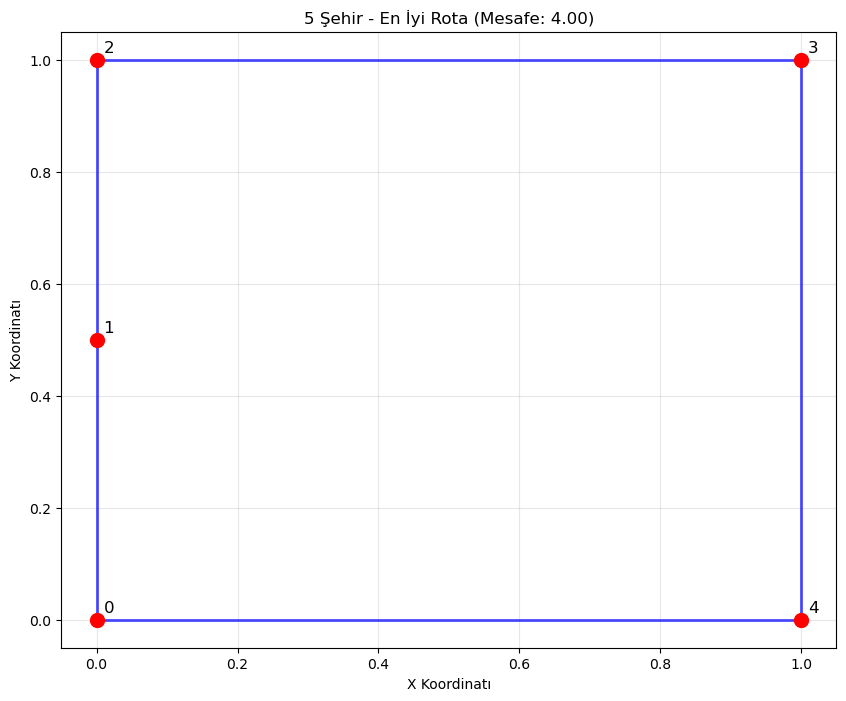

In [21]:
best_score_5 = float('inf')
best_runtime_5 = float('inf')
best_params_5 = None
best_individual_5 = None
best_ga_5 = None

param_grid = {
    'mutation_rate': [0.01, 0.02],
    'termination': [50, 100, 200], 
    'pop_size': [50, 100, 200],
    'crossover_rate': [0.1, 0.5, 0.8],
    'elitism_rate': [0.05, 0.1],
    'tournament_size': [3, 5]
}


for params in ParameterGrid(param_grid):
    print("Test ediliyor:", params)
    ga = GA(cities=cities[min_size], **params)
    best_individual, runtime = ga.run()
    best_distance = best_individual.get_total_distance()

    if best_distance < best_score_5 or (
        best_distance == best_score_5 and runtime < best_runtime_5):
        best_score_5 = best_distance
        best_runtime_5 = runtime
        best_params_5 = params.copy()
        best_individual_5 = best_individual
        best_ga_5         = ga

print("✅ 5 şehirli en iyi skor:", best_score_5)
print("🎯 5 şehirli en iyi parametre:", best_params_5)
print("🧭 5 şehirli en iyi runtime:", best_runtime_5)
print("🗺️ 5 şehirli en iyi rota grafiği:")
best_ga_5.plot_tour(best_individual_5)

For 5-cities TSP, best parameters;
- mutation_rate = 0.01
- termination = 100, 
- pop_size = 50, 
- crossover_rate = 0.1

### 70-Cities TSP

🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 3187.44
   En kötü: 4233.25
   Ortalama: 3651.03
   Nesil 0: 0 mutasyon yapıldı
   Nesil 0: En iyi = 3130.92
   Nesil 100: 2 mutasyon yapıldı
   Nesil 100: En iyi = 1807.84

 SONUÇLAR:
   İlk en iyi : 3187.44
   Final en iyi : 1745.00
   İyileştirme : 45.3%
   En iyi rota : [52, 60, 53, 58, 49, 37, 48, 19, 17, 63, 30, 69, 47, 57, 1, 15, 25, 10, 61, 8, 7, 27, 23, 35, 50, 14, 2, 34, 33, 65, 39, 3, 59, 9, 51, 6, 21, 26, 18, 12, 29, 45, 20, 44, 16, 31, 28, 24, 68, 55, 43, 4, 5, 64, 46, 67, 32, 54, 13, 42, 66, 11, 22, 0, 56, 36, 41, 62, 38, 40]
   Runtime : 0.1800 s
En iyi mesafe: 1745.00


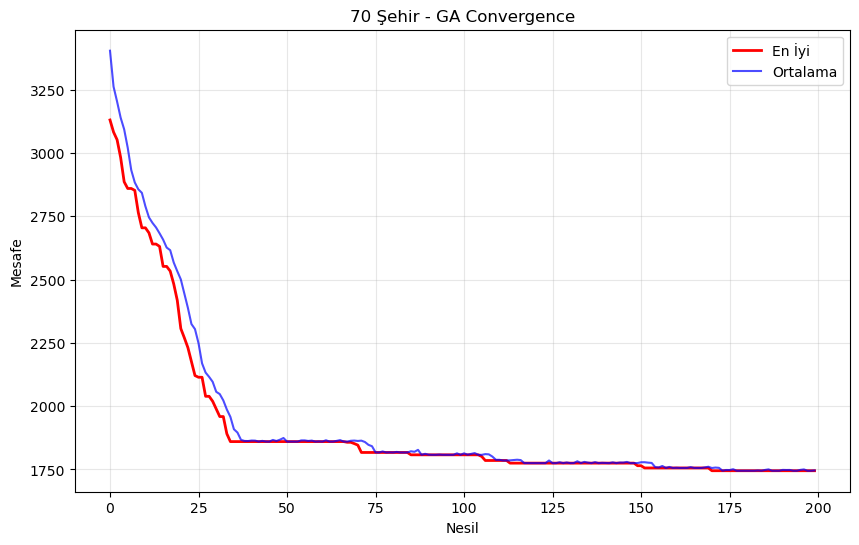

🗺️ Route grafiği çiziliyor...


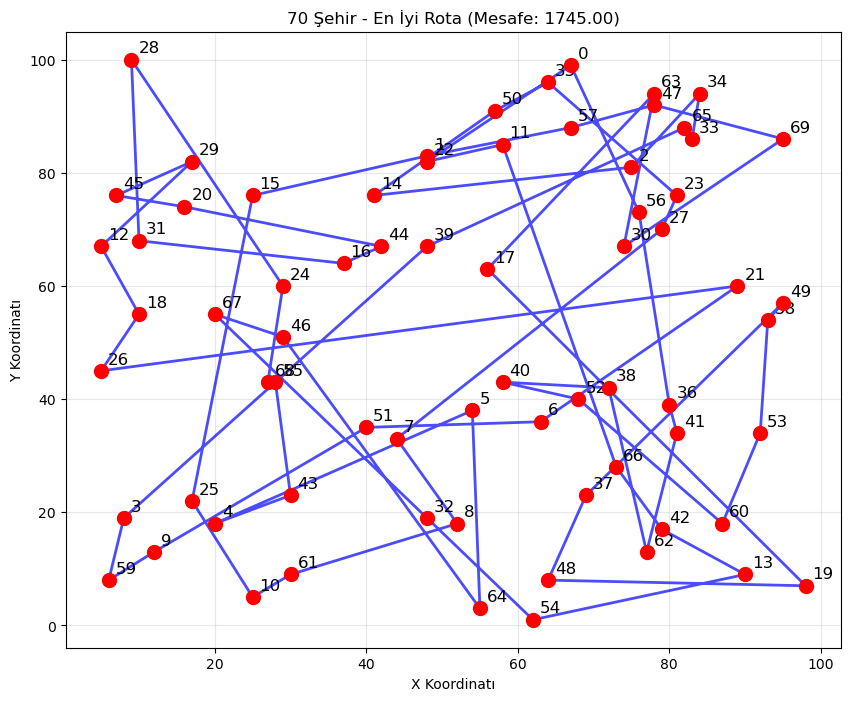

In [24]:
try:
    ga_real = GA(cities[avg_size], 
                     pop_size=50, 
                     termination=200,
                     crossover_rate=0.8,
                     mutation_rate=0.02)
        
    best_solution, best_runtime = ga_real.run()
        
    print(f"En iyi mesafe: {best_solution.get_total_distance():.2f}")
        
    ga_real.plot_convergence()
        
    if avg_size <= 100:
        print("🗺️ Route grafiği çiziliyor...")
        ga_real.plot_tour()
        
except Exception as e:
    print(f"❌ Gerçek veri hatası: {e}")
    traceback.print_exc()

Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 100, 'termination': 200, 'tournament_size': 3}
🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 3167.97
   En kötü: 4003.25
   Ortalama: 3642.54
   Nesil 0: 0 mutasyon yapıldı
   Nesil 0: En iyi = 3167.97
   Nesil 100: 1 mutasyon yapıldı
   Nesil 100: En iyi = 2427.47

 SONUÇLAR:
   İlk en iyi : 3167.97
   Final en iyi : 2095.67
   İyileştirme : 33.8%
   En iyi rota : [46, 7, 5, 8, 37, 42, 62, 10, 61, 9, 28, 18, 25, 50, 0, 31, 20, 15, 1, 12, 26, 32, 49, 53, 48, 66, 43, 3, 59, 67, 56, 23, 33, 16, 39, 6, 52, 41, 60, 13, 19, 64, 55, 27, 36, 54, 69, 21, 38, 17, 22, 44, 35, 63, 24, 4, 51, 68, 45, 29, 47, 2, 65, 34, 11, 14, 57, 30, 58, 40]
   Runtime : 0.1464 s
Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 100, 'termination': 200, 'tournament_size': 5}
🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 3249.78
   En kötü

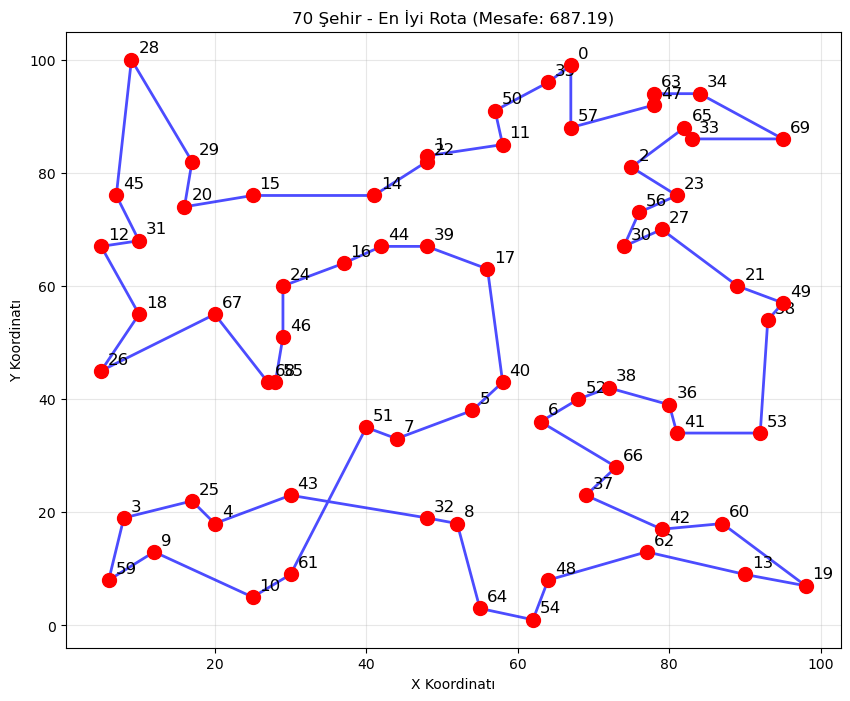

In [25]:
best_score_70 = float('inf')
best_runtime_70 = float('inf')
best_params_70 = None
best_individual_70 = None
best_ga_70 = None

param_grid = {
    'mutation_rate': [0.01, 0.02, 0.05],
    'termination': [200, 500, 1000], 
    'pop_size': [100, 1000, 5000],
    'crossover_rate': [0.1, 0.5, 0.8],
    'elitism_rate': [0.05, 0.1],
    'tournament_size': [3, 5]
}


for params in ParameterGrid(param_grid):
    print("Test ediliyor:", params)
    ga = GA(cities=cities[avg_size], **params)
    best_individual, runtime = ga.run()
    best_distance = best_individual.get_total_distance()

    if best_distance < best_score_70 or (
        best_distance == best_score_70 and runtime < best_runtime_70):
        best_score_70 = best_distance
        best_runtime_70 = runtime
        best_params_70 = params.copy()
        best_individual_70 = best_individual
        best_ga_70         = ga

print("✅ 70 şehirli en iyi skor:", best_score_70)
print("🎯 70 şehirli en iyi parametre:", best_params_70)
print("🧭 70 şehirli en iyi runtime:", best_runtime_70)
print("🗺️ 70 şehirli en iyi rota grafiği:")
best_ga_70.plot_tour(best_individual_70)

For 70-cities TSP, best parameters;
- mutation_rate = 0.05
- termination = 500, 
- pop_size = 5000, 
- crossover_rate = 0.8
- elitism_rate = 0.1
- tournament_size = 3

### 100-Cities TSP

🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 153847.25
   En kötü: 193466.38
   Ortalama: 170542.97
   Nesil 0: 2 mutasyon yapıldı
   Nesil 0: En iyi = 150229.19
   Nesil 100: 3 mutasyon yapıldı
   Nesil 100: En iyi = 91794.05

 SONUÇLAR:
   İlk en iyi : 153847.25
   Final en iyi : 78864.19
   İyileştirme : 48.7%
   En iyi rota : [17, 42, 98, 39, 2, 68, 50, 9, 35, 76, 0, 40, 30, 32, 1, 88, 4, 36, 58, 92, 20, 63, 80, 5, 46, 53, 14, 55, 23, 26, 69, 61, 56, 29, 15, 75, 71, 38, 13, 18, 93, 89, 66, 64, 21, 72, 79, 97, 95, 10, 77, 91, 57, 19, 67, 48, 60, 81, 16, 62, 44, 86, 74, 6, 11, 94, 59, 33, 37, 28, 87, 85, 7, 25, 82, 34, 27, 47, 12, 24, 41, 65, 70, 96, 84, 8, 43, 73, 3, 22, 51, 31, 99, 83, 52, 90, 49, 78, 45, 54]
   Runtime : 0.2983 s
En iyi mesafe: 78864.19


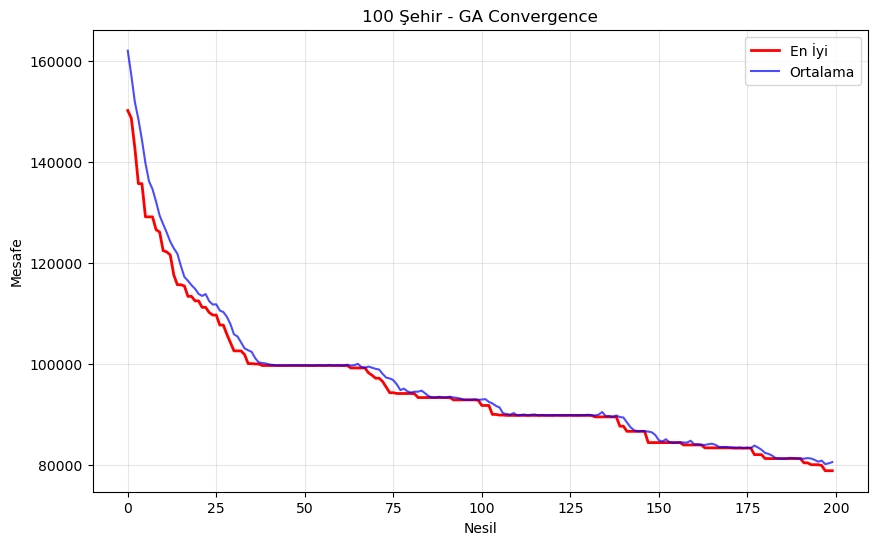

🗺️ Route grafiği çiziliyor...


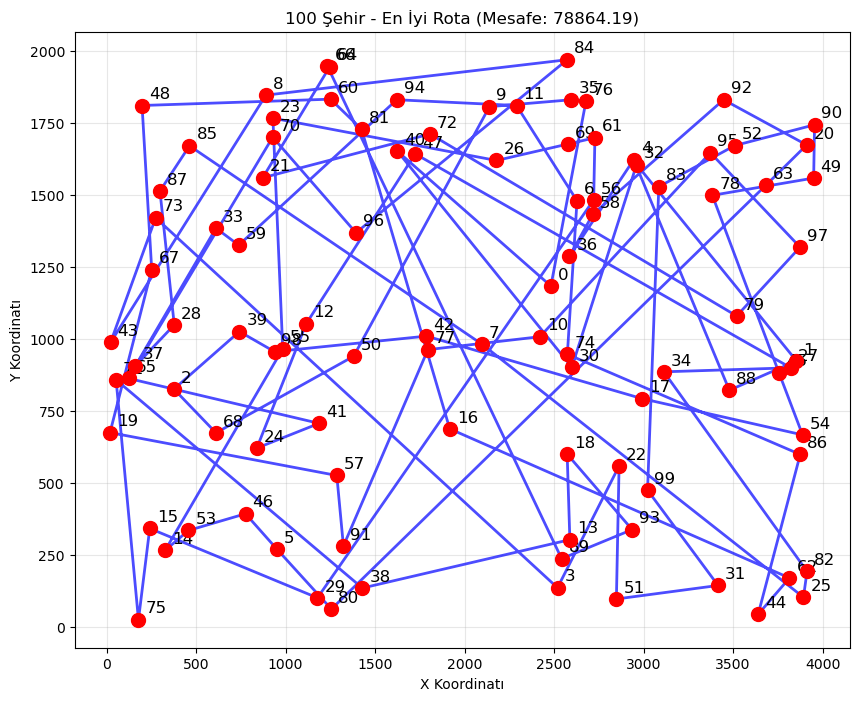

In [28]:
try:
    ga_real = GA(cities[max_size], 
                     pop_size=50, 
                     termination=200,
                     crossover_rate=0.8,
                     mutation_rate=0.02)
        
    best_solution, best_runtime = ga_real.run()
        
    print(f"En iyi mesafe: {best_solution.get_total_distance():.2f}")
        
    ga_real.plot_convergence()
        
    if max_size <= 100:
        print("🗺️ Route grafiği çiziliyor...")
        ga_real.plot_tour()
        
except Exception as e:
    print(f"❌ Gerçek veri hatası: {e}")
    traceback.print_exc()

Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_size': 100, 'termination': 200, 'tournament_size': 3}
🧬 GA başlıyor (200 nesil)...
✅ İlk populasyon hazır:
   En iyi: 158261.59
   En kötü: 189514.64
   Ortalama: 171377.94
   Nesil 0: 1 mutasyon yapıldı
   Nesil 0: En iyi = 149824.74
   Nesil 100: 2 mutasyon yapıldı
   Nesil 100: En iyi = 116691.60

 SONUÇLAR:
   İlk en iyi : 158261.59
   Final en iyi : 105685.15
   İyileştirme : 33.2%
   En iyi rota : [17, 64, 81, 66, 52, 78, 63, 48, 73, 87, 11, 62, 82, 3, 89, 65, 2, 88, 27, 90, 35, 4, 40, 26, 93, 30, 7, 79, 8, 23, 19, 34, 1, 95, 10, 67, 33, 59, 80, 29, 42, 16, 21, 50, 54, 22, 32, 9, 60, 84, 39, 43, 24, 53, 91, 57, 5, 41, 15, 68, 94, 12, 6, 70, 61, 97, 92, 83, 36, 49, 20, 13, 38, 28, 14, 96, 47, 58, 99, 76, 69, 77, 75, 46, 71, 98, 18, 44, 86, 45, 56, 85, 37, 55, 72, 0, 74, 51, 31, 25]
   Runtime : 0.1977 s
Test ediliyor: {'crossover_rate': 0.1, 'elitism_rate': 0.05, 'mutation_rate': 0.01, 'pop_si

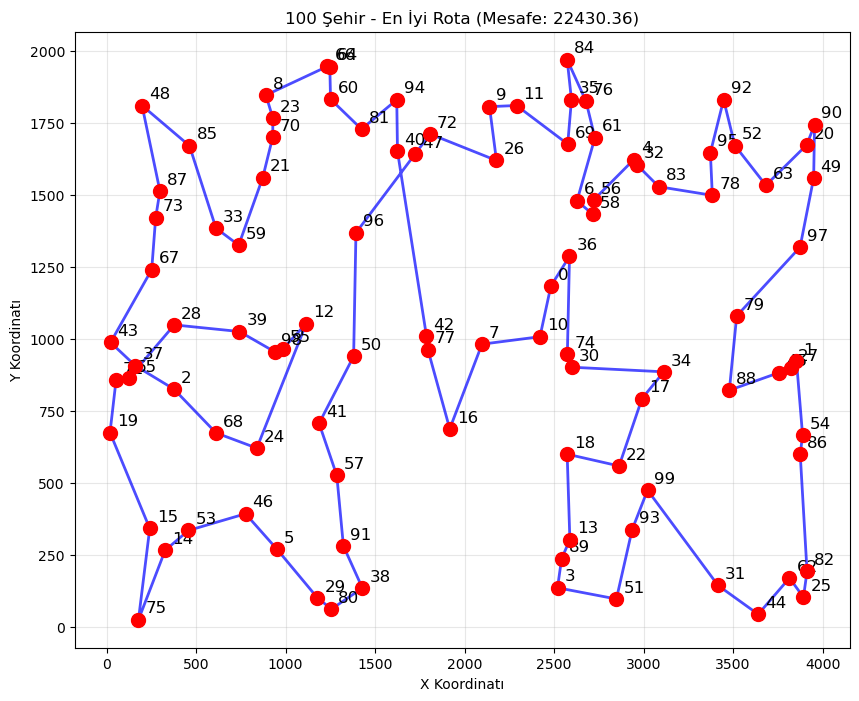

In [29]:
best_score_100 = float('inf')
best_runtime_100 = float('inf')
best_params_100 = None
best_individual_100 = None
best_ga_100 = None

param_grid = {
    'mutation_rate': [0.01, 0.02, 0.05],
    'termination': [200, 500, 1000], 
    'pop_size': [100, 1000, 5000],
    'crossover_rate': [0.1, 0.5, 0.8],
    'elitism_rate': [0.05, 0.1],
    'tournament_size': [3, 5]
}


for params in ParameterGrid(param_grid):
    print("Test ediliyor:", params)
    ga = GA(cities=cities[max_size], **params)
    best_individual, runtime = ga.run()
    best_distance = best_individual.get_total_distance()

    if best_distance < best_score_100 or (
        best_distance == best_score_100 and runtime < best_runtime_100):
        best_score_100        = best_distance
        best_runtime_100      = runtime
        best_params_100       = params.copy()
        best_individual_100   = best_individual
        best_ga_100           = ga

print("✅ 100 şehirli en iyi skor:", best_score_100)
print("🎯 100 şehirli en iyi parametre:", best_params_100)
print("🧭 En iyi runtime:", best_runtime_100)
print("🗺️ 100 şehirli en iyi rota grafiği:")
best_ga_100.plot_tour(best_individual_100)

For 100-cities TSP, best parameters;
- mutation_rate = 0.02
- termination = 500, 
- pop_size = 5000, 
- crossover_rate = 0.8
- elitism_rate = 0.1
- tournament_size = 3